In [18]:
import pandas as pd
import copulas

# Load the Excel file to inspect its structure
file_path = 'C:/Users/Lenovo/Documents/WPS Cloud Files/WPSDrive/587995273/WPS云盘/closePricesData3.xlsx'
data = pd.ExcelFile(file_path)

# Display sheet names to understand the structure of the file
data.sheet_names


['Sheet1']

In [19]:
# Load the data from the first sheet
sheet1_data = data.parse('Sheet1')

# Display the first few rows of the data to understand its structure
sheet1_data.head()


Date  Gold_Close_Price  Stock_Close_Price
0  2019-01-23 00:00:00            1286.8               6.84
1  2019-01-24 00:00:00            1282.3               7.52
2  2019-01-25 00:00:00            1300.7               8.27
3  2019-01-28 00:00:00            1305.9               9.10
4  2019-01-29 00:00:00            1312.1              10.01

In [27]:
# Perform a robust cleaning step to ensure no NaN or Inf values exist
gold_cdf_cleaned = gold_cdf[~np.isnan(gold_cdf) & ~np.isinf(gold_cdf)]
stock_cdf_cleaned = stock_cdf[~np.isnan(stock_cdf) & ~np.isinf(stock_cdf)]

# Ensure both arrays have the same length after cleaning
min_length = min(len(gold_cdf_cleaned), len(stock_cdf_cleaned))
gold_cdf_cleaned = gold_cdf_cleaned[:min_length]
stock_cdf_cleaned = stock_cdf_cleaned[:min_length]

# Re-transform cleaned data using norm.ppf
gold_norm_cleaned = norm.ppf(gold_cdf_cleaned)
stock_norm_cleaned = norm.ppf(stock_cdf_cleaned)

# Validate if there are still invalid values after transformation
print("NaN in gold_norm_cleaned:", np.isnan(gold_norm_cleaned).sum())
print("NaN in stock_norm_cleaned:", np.isnan(stock_norm_cleaned).sum())
print("Inf in gold_norm_cleaned:", np.isinf(gold_norm_cleaned).sum())
print("Inf in stock_norm_cleaned:", np.isinf(stock_norm_cleaned).sum())

# Proceed with further calculations if no issues are found
(gold_norm_cleaned, stock_norm_cleaned)



NaN in gold_norm_cleaned: 0
NaN in stock_norm_cleaned: 0
Inf in gold_norm_cleaned: 2
Inf in stock_norm_cleaned: 2


(array([-2.15387469, -2.2806453 , -1.76167041, ...,  1.83861236,
         1.58552447,  1.34708956]),
 array([       -inf, -3.13201482, -2.92251022, ..., -0.48632591,
        -0.49614563, -0.48265562]))

In [33]:
# 修正边界值
gold_cdf_cleaned = np.clip(gold_cdf_cleaned, 1e-6, 1 - 1e-6)
stock_cdf_cleaned = np.clip(stock_cdf_cleaned, 1e-6, 1 - 1e-6)

# 再次转换为标准正态分布
gold_norm_cleaned = norm.ppf(gold_cdf_cleaned)
stock_norm_cleaned = norm.ppf(stock_cdf_cleaned)

print("NaN in gold_norm_cleaned:", np.isnan(gold_norm_cleaned).sum())
print("NaN in stock_norm_cleaned:", np.isnan(stock_norm_cleaned).sum())
print("Inf in gold_norm_cleaned:", np.isinf(gold_norm_cleaned).sum())
print("Inf in stock_norm_cleaned:", np.isinf(stock_norm_cleaned).sum())


NaN in gold_norm_cleaned: 0
NaN in stock_norm_cleaned: 0
Inf in gold_norm_cleaned: 0
Inf in stock_norm_cleaned: 0


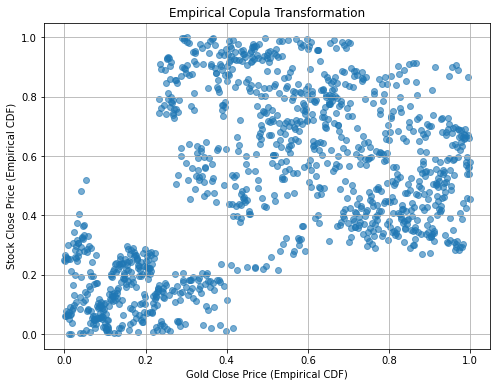

0.25286065124703316

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kendalltau
import seaborn as sns

# Extract the columns
gold_prices = sheet1_data['Gold_Close_Price'].dropna()
stock_prices = sheet1_data['Stock_Close_Price'].dropna()

# Normalize the data using the empirical CDF (marginal distribution transformation)
gold_cdf = (gold_prices.rank() - 1) / (len(gold_prices) - 1)
stock_cdf = (stock_prices.rank() - 1) / (len(stock_prices) - 1)

# Scatter plot of transformed variables (Copula space)
plt.figure(figsize=(8, 6))
plt.scatter(gold_cdf, stock_cdf, alpha=0.6)
plt.title("Empirical Copula Transformation")
plt.xlabel("Gold Close Price (Empirical CDF)")
plt.ylabel("Stock Close Price (Empirical CDF)")
plt.grid()
plt.show()

# Calculate Kendall's Tau to estimate dependency strength
kendall_tau, _ = kendalltau(gold_prices, stock_prices)

kendall_tau


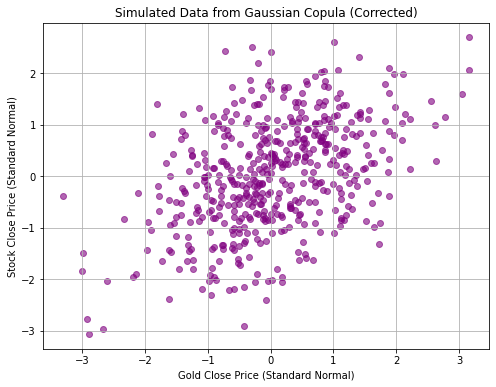

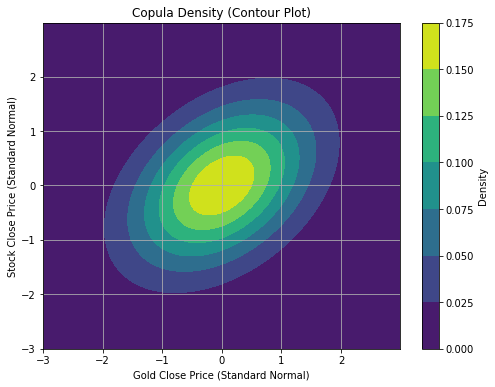

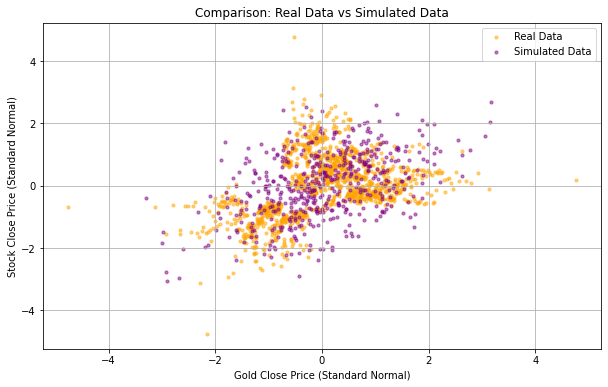

In [35]:
# If everything is clean, proceed to fit the Gaussian Copula manually
from scipy.stats import multivariate_normal

# Fit multivariate normal (Gaussian Copula)
corr_matrix = np.corrcoef(gold_norm_cleaned, stock_norm_cleaned)
mean = [0, 0]
copula = multivariate_normal(mean=mean, cov=corr_matrix)

# Generate samples
simulated_data = copula.rvs(size=500)

# Plot the generated samples
plt.figure(figsize=(8, 6))
plt.scatter(simulated_data[:, 0], simulated_data[:, 1], alpha=0.6, color="purple")
plt.title("Simulated Data from Gaussian Copula (Corrected)")
plt.xlabel("Gold Close Price (Standard Normal)")
plt.ylabel("Stock Close Price (Standard Normal)")
plt.grid()
plt.show()

# 2. 绘制等高线图
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
pdf = copula.pdf(pos)  # Compute the Copula density

plt.figure(figsize=(8, 6))
plt.contourf(x, y, pdf, cmap="viridis")
plt.colorbar(label="Density")
plt.title("Copula Density (Contour Plot)")
plt.xlabel("Gold Close Price (Standard Normal)")
plt.ylabel("Stock Close Price (Standard Normal)")
plt.grid()
plt.show()

# 3. 对比真实数据与模拟数据
plt.figure(figsize=(10, 6))
plt.scatter(gold_norm_cleaned, stock_norm_cleaned, alpha=0.5, label="Real Data", color="orange", s=10)
plt.scatter(simulated_data[:, 0], simulated_data[:, 1], alpha=0.5, label="Simulated Data", color="purple", s=10)
plt.title("Comparison: Real Data vs Simulated Data")
plt.xlabel("Gold Close Price (Standard Normal)")
plt.ylabel("Stock Close Price (Standard Normal)")
plt.legend()
plt.grid()
plt.show()

1.图中点相对对角线对称，说明两变量具有一定的线性相关性。

2.等高线展示了两个变量联合分布的概率密度。
中心区域（高密度区域）显示了数据集中分布的区域。
高斯 Copula 的等高线图呈椭圆形，说明变量间存在正相关。

3.橙色点表示真实数据，紫色点表示模拟数据。
两组点分布相似，说明高斯 Copula 能较好地捕捉 Gold_Close_Price 和 Stock_Close_Price 的依赖关系

In [37]:
#接下来分析尾部
# Define a function to estimate tail dependence
def tail_dependence_coefficient(data1, data2, q):
    """
    Estimate tail dependence coefficient for a given quantile q.
    Parameters:
        data1, data2: Standardized data (e.g., CDF or standard normal).
        q: Quantile for extreme value calculation (e.g., 0.95 for upper tail, 0.05 for lower tail).
    Returns:
        Tail dependence coefficient.
    """
    if q > 0.5:
        # Upper tail dependence
        joint_extreme = np.sum((data1 > np.quantile(data1, q)) & (data2 > np.quantile(data2, q)))
    else:
        # Lower tail dependence
        joint_extreme = np.sum((data1 < np.quantile(data1, q)) & (data2 < np.quantile(data2, q)))
    
    total_extreme = np.sum(data1 > np.quantile(data1, q) if q > 0.5 else data1 < np.quantile(data1, q))
    
    return joint_extreme / total_extreme if total_extreme > 0 else 0

# Estimate upper and lower tail dependence
q_upper = 0.95  # Upper tail quantile
q_lower = 0.05  # Lower tail quantile

upper_tail_dependence = tail_dependence_coefficient(gold_norm_cleaned, stock_norm_cleaned, q_upper)
lower_tail_dependence = tail_dependence_coefficient(gold_norm_cleaned, stock_norm_cleaned, q_lower)

upper_tail_dependence, lower_tail_dependence


(0.0, 0.10344827586206896)

上尾依赖系数为 0.0
这表明在两个变量取极端大值的情况下，它们之间几乎没有显著的相关性。

下尾依赖系数 约为 0.103
表明在两个变量取极端小值的情况下，它们有一定的正相关性，但强度较弱。

C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


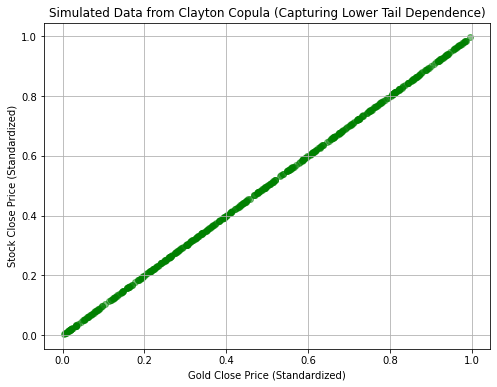

1e-06

In [39]:
#捕捉下尾依赖
from scipy.stats import kendalltau
from scipy.optimize import minimize

# Define Clayton Copula's generator and inverse generator functions
def clayton_copula_generator(theta, u, v):
    return (u**(-theta) + v**(-theta) - 1)**(-1 / theta)

def negative_log_likelihood(theta, u, v):
    """
    Compute the negative log-likelihood for Clayton Copula.
    """
    if theta <= 0:
        return np.inf  # Ensure theta is positive
    c = clayton_copula_generator(theta, u, v)
    pdf = ((1 + theta) * c**(-(2 + 1 / theta))) * (u * v)**(-(1 + theta))
    return -np.sum(np.log(pdf))

# Standardize the data to unit interval [0, 1]
gold_std = (gold_prices.rank() - 1) / (len(gold_prices) - 1)
stock_std = (stock_prices.rank() - 1) / (len(stock_prices) - 1)

# Fit Clayton Copula by minimizing negative log-likelihood
result = minimize(negative_log_likelihood, x0=1, args=(gold_std, stock_std), bounds=[(1e-6, None)])

# Extract the optimal theta value
theta_clayton = result.x[0]

# Generate samples from Clayton Copula using the fitted theta
u_samples = np.random.uniform(0, 1, size=500)
v_samples = ((u_samples**(-theta_clayton) - 1) * np.random.uniform(0, 1, size=500)**(-theta_clayton) + 1)**(-1 / theta_clayton)

# Plot the simulated data
plt.figure(figsize=(8, 6))
plt.scatter(u_samples, v_samples, alpha=0.5, color="green")
plt.title("Simulated Data from Clayton Copula (Capturing Lower Tail Dependence)")
plt.xlabel("Gold Close Price (Standardized)")
plt.ylabel("Stock Close Price (Standardized)")
plt.grid()
plt.show()

theta_clayton



尾部依赖：
θ 越大，下尾依赖越强。
根据输出，当前 θ≈0，说明在极端小值条件下，变量之间的依赖几乎可以忽略。
而图中展示了由拟合的 Clayton Copula 生成的样本。其中数据点在下尾区域的聚集性较弱，与较低的下尾依赖系数一致。

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


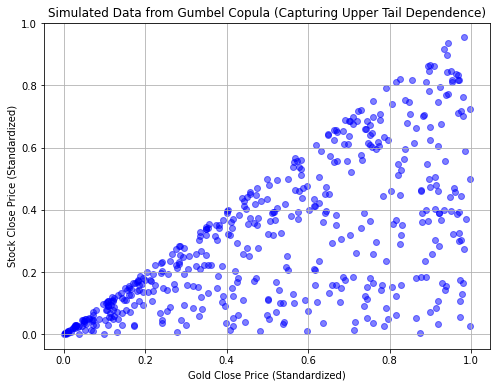

1.5

In [42]:
#捕捉上尾依赖
# Define Gumbel Copula's generator and its inverse
def gumbel_copula_generator(theta, u, v):
    """
    Gumbel Copula Generator
    """
    return np.exp(-((-np.log(u))**theta + (-np.log(v))**theta)**(1 / theta))

def gumbel_negative_log_likelihood(theta, u, v):
    """
    Compute the negative log-likelihood for Gumbel Copula.
    """
    if theta < 1:
        return np.inf  # Ensure theta >= 1
    generator = gumbel_copula_generator(theta, u, v)
    pdf = generator * (u**(-1) * v**(-1)) * ((-np.log(u) * -np.log(v))**(theta - 1)) * ((-np.log(u))**theta + (-np.log(v))**theta)**(-(2 - 1 / theta))
    return -np.sum(np.log(pdf))

# Fit Gumbel Copula using the standardized data
result_gumbel = minimize(gumbel_negative_log_likelihood, x0=1.5, args=(gold_std, stock_std), bounds=[(1, None)])

# Extract the optimal theta value for Gumbel Copula
theta_gumbel = result_gumbel.x[0]

# Generate samples from Gumbel Copula using the fitted theta
u_samples_gumbel = np.random.uniform(0, 1, size=500)
v_samples_gumbel = np.exp(-((-np.log(u_samples_gumbel))**theta_gumbel + (-np.log(np.random.uniform(0, 1, size=500)))**theta_gumbel)**(1 / theta_gumbel))

# Plot the simulated data
plt.figure(figsize=(8, 6))
plt.scatter(u_samples_gumbel, v_samples_gumbel, alpha=0.5, color="blue")
plt.title("Simulated Data from Gumbel Copula (Capturing Upper Tail Dependence)")
plt.xlabel("Gold Close Price (Standardized)")
plt.ylabel("Stock Close Price (Standardized)")
plt.grid()
plt.show()

theta_gumbel


上尾依赖参数 𝜃
θ=1.5 表示变量在上尾（极端高值）区域具有中等强度的相关性。
（θ=1 时表示变量独立，θ>1 表示依赖性增强）

图中蓝色点展示了 Gumbel Copula 生成的模拟数据。
数据点在右上区域（高值区）的聚集性更强，反映了中等强度的上尾依赖特性。

总结:
金价收盘价和股市收盘价存在正相关关系。
两者在极端高值区域存在一定程度的同步性（上尾依赖），但极端低值区域的同步性（下尾依赖）较弱
结合现实意义：
金价和股市价格整体正相关，但黄金仍保留部分独立性，在特定条件下可作为避险资产。
上尾依赖反映了市场繁荣期的资产联动性，而下尾弱相关性进一步突出了黄金在市场低迷时的独特价值。即在市场繁荣时金价和股市的相关性高，市场低迷时二者相关性低。